In [ ]:
from polymer_gc.polymer_graph import SimSEC
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pathlib
import pickle
datadir=pathlib.Path(".").absolute()/"data"/"pred_mn"
if not datadir.exists():
    datadir.mkdir(parents=True)

In [ ]:
# Parameters for the histogram
log_start = 1  # log10(x) = 1 => x = 10
log_end = 7    # log10(x) = 3 => x = 1000
mn_min = 1e3
mn_mass = 1e6
N=50_000 # Number of generated SECs
num_bins = 100   # Number of bins between log_start and log_end
rng= np.random.default_rng(42)

bin_edges = np.linspace(log_start, log_end, num_bins + 1)


log_mnmin = np.log10(mn_min) 
log_mnmax = np.log10(mn_mass)
for i in tqdm(range(N), desc="Simulating SEC", unit="run",total=N):
    mn= int(10**(rng.random()*(log_mnmax-log_mnmin) + log_mnmin)) # np.random.randint(1000, 1_000_000)
    pdi=1+rng.random() # np.random.rand()
    mw=mn*pdi
    file =datadir/f"mn_{mn}_pdi_{pdi:.2f}.pkl"
    if file.exists():
        continue    


    sec = SimSEC.from_mn_mw(
        mn,
        mw,
        random_state=mn
        )
    # sec.plot()
    sec.autodetect_signal_boarders()
    if len(sec.signal_boarders) !=1:
        continue

    masses = sec.mass_range
    lower_mass_cutoff = masses[sec.signal_boarders[0][1]]
    upper_mass_cutoff = masses[sec.signal_boarders[0][0]]
    log_mwd,mwdmasses = sec.calc_logMW(lower_mass_cutoff, upper_mass_cutoff)

    log_masses = np.log10(mwdmasses)
    mask = (log_masses >= log_start) & (log_masses <= log_end)
    filtered_logx = log_masses[mask]
    filtered_y = log_mwd[mask,0]
    bin_indices = np.digitize(filtered_logx, bin_edges) - 1
    hist = np.zeros(num_bins)
    for i in range(num_bins):
        values = filtered_y[bin_indices == i]
        if len(values) > 0:
            hist[i] = values.mean()
    

    data={
        "mass_params":sec.calc_mass_params(
            lower_mass_cutoff, upper_mass_cutoff
        ),
        "hist":hist
    }
    # Save the data to a file
    with open(file, "wb") as f:

        pickle.dump(data, f)


Simulating SEC: 100%|██████████| 1000/1000 [00:07<00:00, 128.14run/s]


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

files=datadir.glob("*.pkl")
# randomly shuffle the files
files = list(files)
rng.shuffle(files)
agg_file=datadir.parent / (datadir.name+".aggr.pckl")
datas={}
if agg_file.exists():
    with open(agg_file, "rb") as f:
        datas = pickle.load(f)
try:
    for file in tqdm(files, desc="Loading data", unit="file",total=len(list(datadir.glob("*.pkl")))):
        if file.name in datas:
            continue
        with open(file, "rb") as f:
            data = pickle.load(f)
        datas[file.name] = data
finally:
    with open(agg_file, "wb") as f:
        pickle.dump(datas, f)
    

Loading data: 100%|██████████| 48352/48352 [00:00<00:00, 813342.91file/s]


In [7]:
print(f"Loaded {len(datas)} files")
y_names = set()
for d in datas.values():
    y_names.update(
        d["mass_params"].keys()
    )
y_names = sorted(y_names)
xs = [
    torch.from_numpy(d["hist"].flatten()) for d in datas.values()
    ]

ys = [
    torch.from_numpy(
        np.log10(np.array([
            d["mass_params"][n]
            for n in y_names
        ]).flatten())
    ) for d in datas.values()
]
indices = np.arange(len(xs))
np.random.shuffle(indices)
xs = [xs[i] for i in indices]
ys = [ys[i] for i in indices]

splits = (8,1,1)



X = torch.stack(xs).float()
Y = torch.stack(ys).float()
x_splits = np.ceil(np.array(splits)*len(X)/sum(splits)).astype(int)
x_splits[-1] = len(X) - sum(x_splits[:-1])
X_train, X_val, X_test = torch.split(X, tuple(x_splits))

y_splits = np.ceil(np.array(splits)*len(Y)/sum(splits)).astype(int)
y_splits[-1] = len(Y) - sum(y_splits[:-1])
Y_train, Y_val, Y_test = torch.split(Y, tuple(y_splits))

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

batch_size = 512

train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Loaded 48352 files


In [8]:

class FunnelNN(torch.nn.Module):
    def __init__(self, input_size, output_size, factor=2, min_hidden=4, activation=torch.nn.ReLU, output_activation=None):
        super().__init__()
        sizes = [(input_size, max(input_size // factor, output_size))]
        while sizes[-1][1] > output_size and sizes[-1][1] >= min_hidden:
            next_out = max(sizes[-1][1] // factor, output_size)
            sizes.append((sizes[-1][1], next_out))

        sizes[-1] = (sizes[-1][0], output_size)

        layers = []
        for in_size, out_size in sizes[:-1]:
            layers.append(torch.nn.Linear(in_size, out_size))
            layers.append(activation())

        layers.append(torch.nn.Linear(sizes[-1][0], sizes[-1][1]))
        if output_activation:
            layers.append(output_activation())

        self.seq = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.seq(x)


nn=FunnelNN(num_bins, 4,factor=21)
optimizer = torch.optim.Adam(nn.parameters(), lr=0.0001)
nn

FunnelNN(
  (seq): Sequential(
    (0): Linear(in_features=100, out_features=4, bias=True)
  )
)

In [9]:
# clear jupyter output
from IPython.display import clear_output

loss_fn = torch.nn.MSELoss()
num_epochs = 300

nn.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
X_train = X_train.to(nn.seq[0].weight.device)
Y_train = Y_train.to(nn.seq[0].weight.device)
X_val = X_val.to(nn.seq[0].weight.device)
Y_val = Y_val.to(nn.seq[0].weight.device)
X_test = X_test.to(nn.seq[0].weight.device)
Y_test = Y_test.to(nn.seq[0].weight.device)
val_loss = 0
train_loss = 0
train_losses = []
val_losses = []

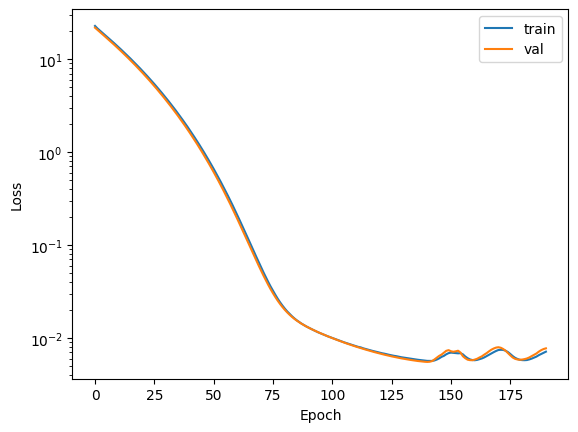

Training:  66%|██████▋   | 199/300 [01:31<00:46,  2.17epoch/s, train_loss=0.00592, val_loss=0.00602]


KeyboardInterrupt: 

In [10]:

with tqdm(desc="Training", unit="epoch",total=num_epochs) as pbar:
    for epoch in range(num_epochs):
        # Training
        pbar.update(1)
        nn.train()
        optimizer.zero_grad()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(nn.seq[0].weight.device)
            y_batch = y_batch.to(nn.seq[0].weight.device)
            y_pred = nn(x_batch)
            loss = loss_fn(y_pred, y_batch)

            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        pbar.set_postfix(train_loss=train_loss, val_loss=val_loss)
        # Validation
        nn.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(nn.seq[0].weight.device)
                y_batch = y_batch.to(nn.seq[0].weight.device)
                y_pred = nn(x_batch)
                val_loss += loss_fn(y_pred, y_batch).item()
        val_loss /= len(val_loader)
        pbar.set_postfix(train_loss=train_loss, val_loss=val_loss)
        val_losses.append(val_loss)

        if epoch % 10 ==0:
            clear_output(wait=True)
            plt.plot(train_losses, label="train")
            plt.plot(val_losses, label="val")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.yscale("log")
            plt.legend()
            plt.show()
            plt.close()
    # Test
    nn.eval()
    test_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(nn.seq[0].weight.device)
            y_batch = y_batch.to(nn.seq[0].weight.device)
            y_pred = nn(x_batch)
            test_loss += loss_fn(y_pred, y_batch).item()


 

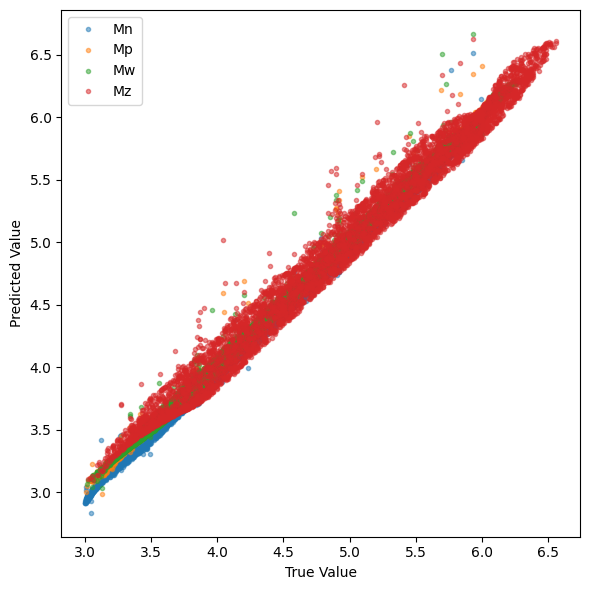

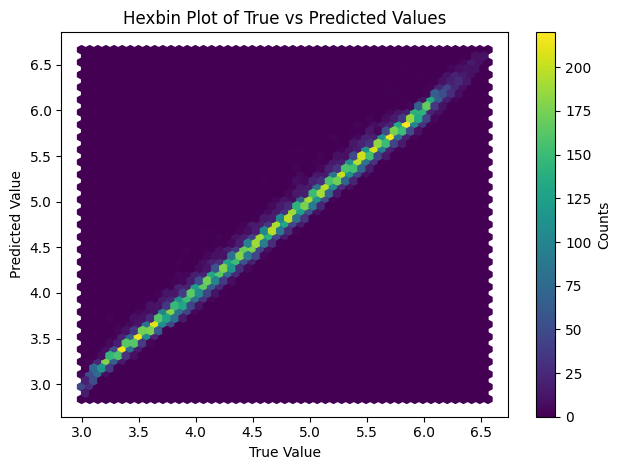

In [11]:
# Plotting the results
plt.figure(figsize=(6, 6))
test_pred = nn(X_test.to(nn.seq[0].weight.device))

for i, y_name in enumerate(y_names):
    plt.plot(Y_test[:, i].detach().cpu().numpy(),test_pred[:, i].detach().cpu().numpy(),".", label=y_name, alpha=0.5)
    

plt.legend()
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.tight_layout()
plt.show()

plt.hexbin(
    Y_test[:,].detach().cpu().numpy().flatten(),
    test_pred[:,].detach().cpu().numpy().flatten(),
    gridsize=50,
    # cmap='Blues',
)
plt.colorbar(label='Counts')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Hexbin Plot of True vs Predicted Values')
plt.tight_layout()
plt.show()


In [12]:
# total number of parameters:
print("Total number of parameters: ", sum(p.numel() for p in nn.parameters()))

Total number of parameters:  404


c:\Users\Julian_Kimmig\Documents\programming\polymer_gc\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


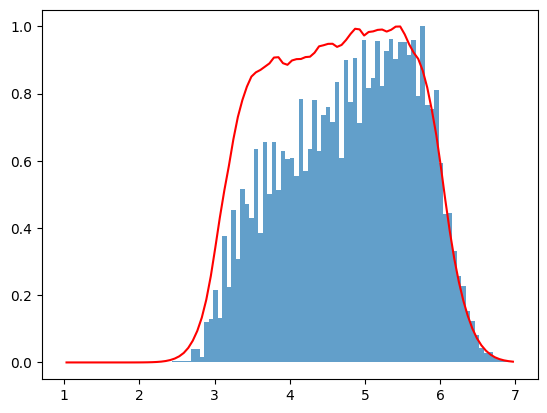

In [13]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(nn)
attdat=X_test[:,:].to(nn.seq[0].weight.device)
attdat.requires_grad_()


attributions, _ = ig.attribute(
    attdat,
    target=0,
    return_convergence_delta=True
)
attributions = attributions.detach().cpu().numpy()

bar_width = bin_edges[1] - bin_edges[0]  # consistent bin width
n_att=np.mean(attributions, axis=0)
n_att = n_att / n_att.max()
plt.bar(x=[(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)],height= n_att, width=bar_width, alpha=0.7, align='center'
        )
dat=np.mean(attdat.detach().cpu().numpy(), axis=0)
dat = dat / dat.max()
plt.plot([(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)],dat,"red")
# def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
#     print(title)
#     for i in range(len(feature_names)):
#         print(feature_names[i], ": ", '%.3f'%(importances[i]))
#     x_pos = (np.arange(len(feature_names)))
#     if plot:
#         plt.figure(figsize=(12,6))
#         plt.bar(x_pos, importances, align='center')
#         plt.xticks(x_pos, feature_names, wrap=True)
#         plt.xlabel(axis_title)
#         plt.title(title)
# visualize_importances(feature_names, np.mean(attributions, axis=0))

In [14]:
bar_width = bin_edges[1] - bin_edges[0]  # consistent bin width

plt.bar(x=[(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)],height=hist, width=bar_width, alpha=0.7, align='center'
        )
plt.plot([(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)],hist,"red")


NameError: name 'hist' is not defined

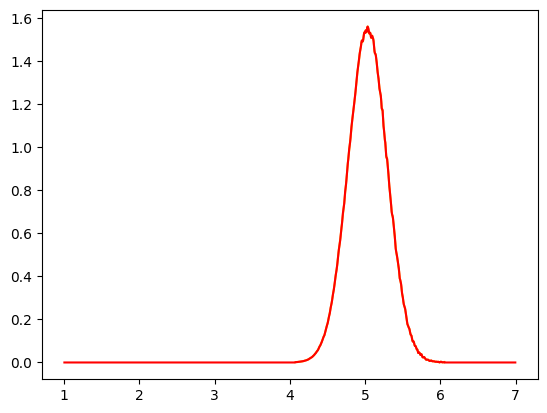

In [ ]:
plt.plot(log_masses,log_mwd,"orange")
plt.plot([(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)],hist,"red")

AttributeError: Rectangle.set() got an unexpected keyword argument 'center'

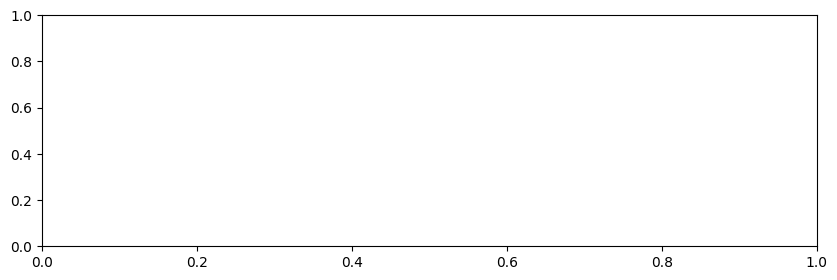

In [56]:
weights = nn.seq[0].weight.detach().cpu().numpy()
biases = nn.seq[0].bias.detach().cpu().numpy()

# weights shape: (4, 100) → 4 outputs (Mn, Mw, etc.), 100 input bins
import matplotlib.pyplot as plt

param_names = y_names  # assuming: ["Mn", "Mw", "Mz", "Mz+1"]
plt.figure(figsize=(10, 3))
for i, param in enumerate(param_names):
    
    plt.bar(range(num_bins), weights[i],
            # bars side by side
            width=0.4, alpha=0.7, label=f"Weight for {param}",
            center =0.4 * i,
            )
plt.title(f"Weight contribution to prediction of {param}")
plt.xlabel("Bin index (log mass bins)")
plt.ylabel("Weight")
plt.show()

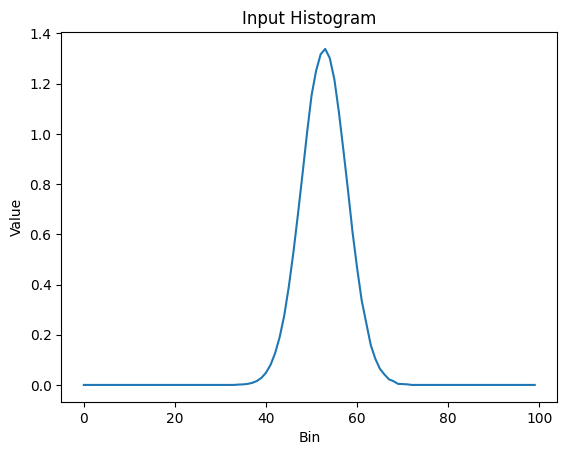

Mn: True = 1.25e+04, Predicted = 1.20e+04
Mp: True = 1.54e+04, Predicted = 1.71e+04
Mw: True = 1.99e+04, Predicted = 2.01e+04
Mz: True = 3.15e+04, Predicted = 2.96e+04


In [19]:
import random

idx = random.randint(0, len(X_test) - 1)
sample = X_test[idx].unsqueeze(0)
true_y = Y_test[idx]
pred_y = nn(sample).detach().cpu().squeeze()

plt.plot(torch.arange(num_bins), sample.cpu().squeeze(), label="Histogram")
plt.title("Input Histogram")
plt.xlabel("Bin")
plt.ylabel("Value")
plt.show()

for i, param in enumerate(param_names):
    print(f"{param}: True = {10**true_y[i]:.2e}, Predicted = {10**pred_y[i]:.2e}")

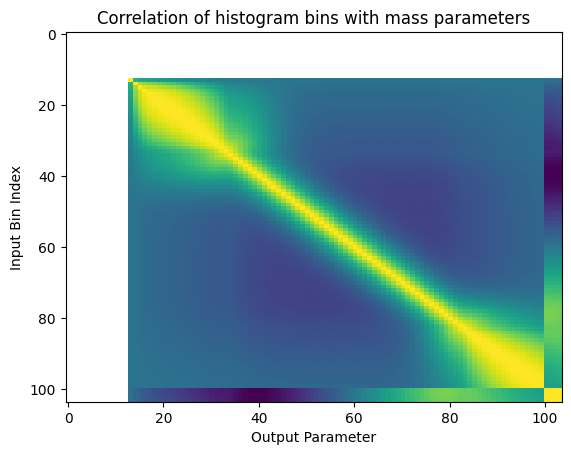

In [28]:

X_np = X.cpu().numpy()
Y_np = Y.cpu().numpy()

corrs = np.corrcoef(X_np.T, Y_np.T)#[0:num_bins, num_bins:]
plt.imshow(corrs,
           # make ratio 1:1
              aspect='auto',
            )
plt.title("Correlation of histogram bins with mass parameters")
plt.xlabel("Output Parameter")
plt.ylabel("Input Bin Index")
plt.show()

In [57]:
nn

FunnelNN(
  (seq): Sequential(
    (0): Linear(in_features=100, out_features=4, bias=True)
  )
)

In [ ]:
sec.plot()

(<Figure size 3600x7200 with 5 Axes>,
 {'raw': <Axes: title={'center': 'SEC Data'}, xlabel='Volume', ylabel='Signal'>,
  'elu': (<Axes: title={'center': 'Elugram'}, xlabel='Volume', ylabel='Signal'>,
   <Axes: ylabel='Mass'>),
  'elu2': <Axes: title={'center': 'Elugram'}, xlabel='Volume', ylabel='Signal'>,
  'mwd': <Axes: xlabel='Mass'>})

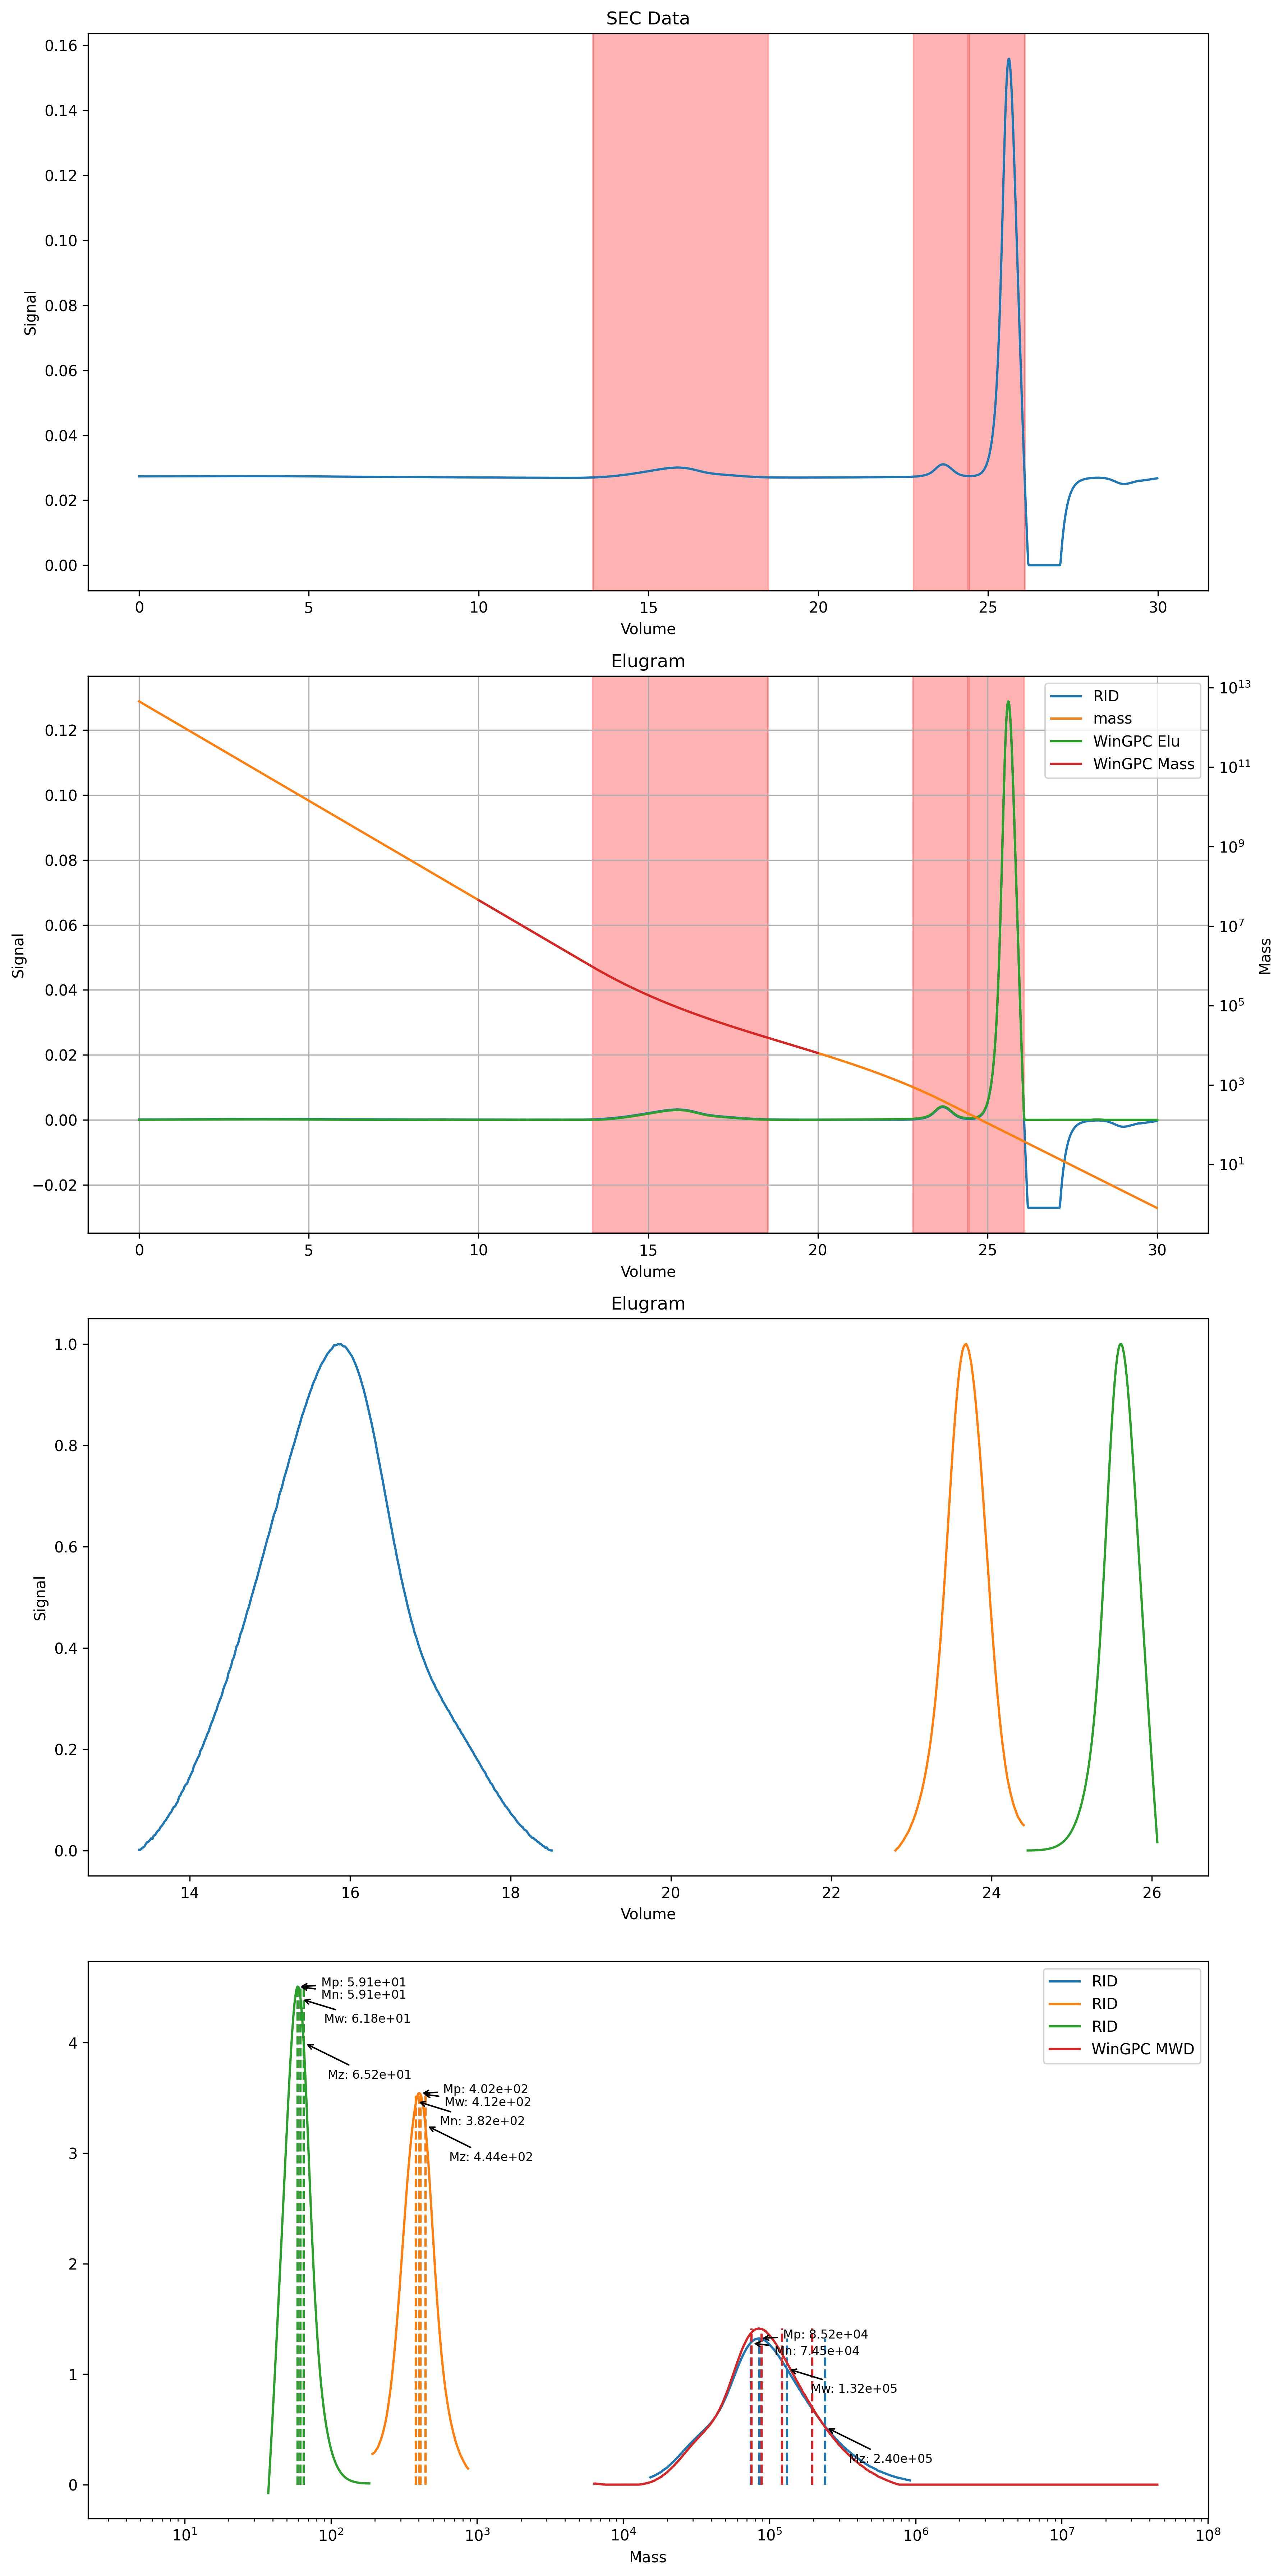

In [39]:
from secanalysis.sec_formats.win_gpc import WinGPCData
sec = WinGPCData.from_file(datadir.parent/"win_gpc_sample.txt")
sec.autodetect_signal_boarders()
sec.plot()


In [66]:
masses = sec.mass_range
lower_mass_cutoff = masses[sec.signal_boarders[0][1]]
upper_mass_cutoff = masses[sec.signal_boarders[0][0]]
log_mwd,mwdmasses = sec.calc_logMW(lower_mass_cutoff, upper_mass_cutoff)

log_masses = np.log10(mwdmasses)
mask = (log_masses >= log_start) & (log_masses <= log_end)
filtered_logx = log_masses[mask]
filtered_y = log_mwd[mask,0]
bin_indices = np.digitize(filtered_logx, bin_edges) - 1
hist = np.zeros(num_bins)
for i in range(num_bins):
    values = filtered_y[bin_indices == i]
    if len(values) > 0:
        hist[i] = values.mean()


data={
    "mass_params":sec.calc_mass_params(
        lower_mass_cutoff, upper_mass_cutoff
    ),
    "hist":hist
}
massparams = sec.calc_mass_params(
        lower_mass_cutoff, upper_mass_cutoff
    )
massparams

{'Mp': array([85207.14923649]),
 'Mn': array([74493.40468593]),
 'Mw': array([131781.94486012]),
 'Mz': array([240353.00083727])}

In [64]:
dict(zip(y_names,list(10**nn(torch.from_numpy(hist).float().unsqueeze(0).to(nn.seq[0].weight.device)).detach().cpu().numpy()[0])))

{'Mn': np.float32(74777.3),
 'Mp': np.float32(107194.11),
 'Mw': np.float32(125074.266),
 'Mz': np.float32(182866.47)}

In [75]:
np.abs(10**nn(torch.from_numpy(hist).float().unsqueeze(0).to(nn.seq[0].weight.device)).detach().cpu().numpy()[0]- np.asarray([massparams[n] for n in y_names]).flatten()) / np.asarray([massparams[n] for n in y_names]).flatten()

array([0.00381097, 0.25804126, 0.05089983, 0.23917543])

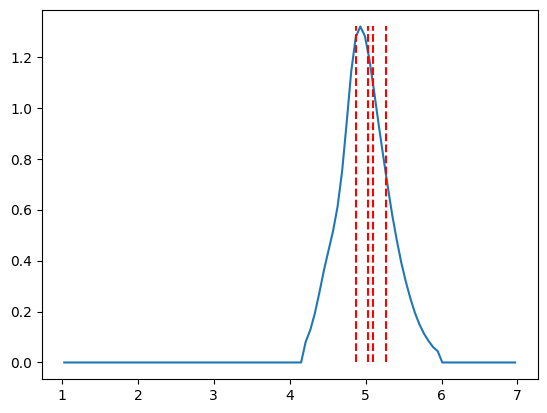

In [65]:
plt.plot(
    [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)],
    hist,
)

plt.vlines(
    nn(torch.from_numpy(hist).float().unsqueeze(0).to(nn.seq[0].weight.device)).detach().cpu().numpy()[0,:],
    ymin=0,
    ymax=hist.max(),
    color="red",
    linestyle="--",
)


In [61]:
y_names

['Mn', 'Mp', 'Mw', 'Mz']